In [3]:
import pandas as pd
import networkx as nx

# Paths to your subset files
nodes_csv = "../data/processed/subset_nodes.csv"
edges_csv = "../data/processed/subset_edges.csv"

# Load
nodes = pd.read_csv(nodes_csv)
edges = pd.read_csv(edges_csv)

# Ensure IDs are numeric
nodes["osmid"] = pd.to_numeric(nodes["osmid"], errors="raise")
edges["u"] = pd.to_numeric(edges["u"], errors="raise")
edges["v"] = pd.to_numeric(edges["v"], errors="raise")

# Build directed graph
G = nx.DiGraph()

# Add nodes with attributes (everything except 'osmid' becomes attributes)
for row in nodes.itertuples(index=False):
    d = row._asdict()
    osmid = int(d.pop("osmid"))
    G.add_node(osmid, **d)

# Add edges with attributes (everything except u,v becomes attributes)
for row in edges.itertuples(index=False):
    d = row._asdict()
    u = int(d.pop("u")); v = int(d.pop("v"))
    G.add_edge(u, v, **d)

print("✅ Graph built:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

✅ Graph built: 1000 nodes, 2551 edges


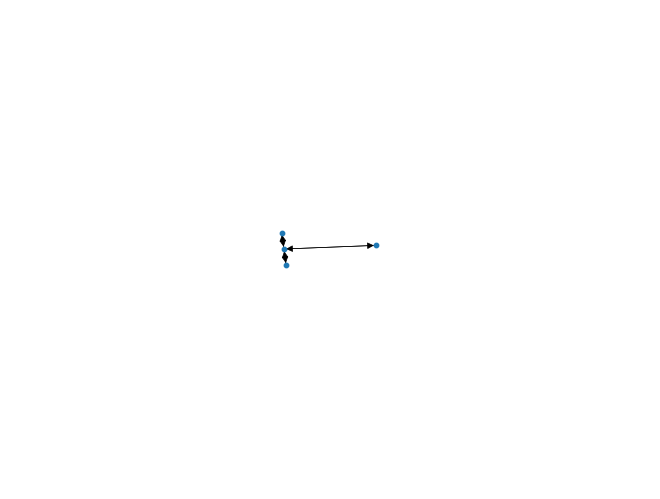

In [4]:
# take a small induced subgraph around a seed node
seed = next(iter(G.nodes()))
nbrs = set(nx.single_source_shortest_path_length(G.to_undirected(), seed, cutoff=2).keys())
V = list(nbrs)[:200]  # cap to 200 nodes for plotting
H = G.subgraph(V).copy()

# quick draw (matplotlib) — positions from (x,y) if available
import matplotlib.pyplot as plt
pos = {n:(d.get("x",0), d.get("y",0)) for n,d in H.nodes(data=True)}
nx.draw(H, pos=pos if all(v!=(0,0) for v in pos.values()) else None,
        node_size=10, width=0.5, with_labels=False)
plt.show()

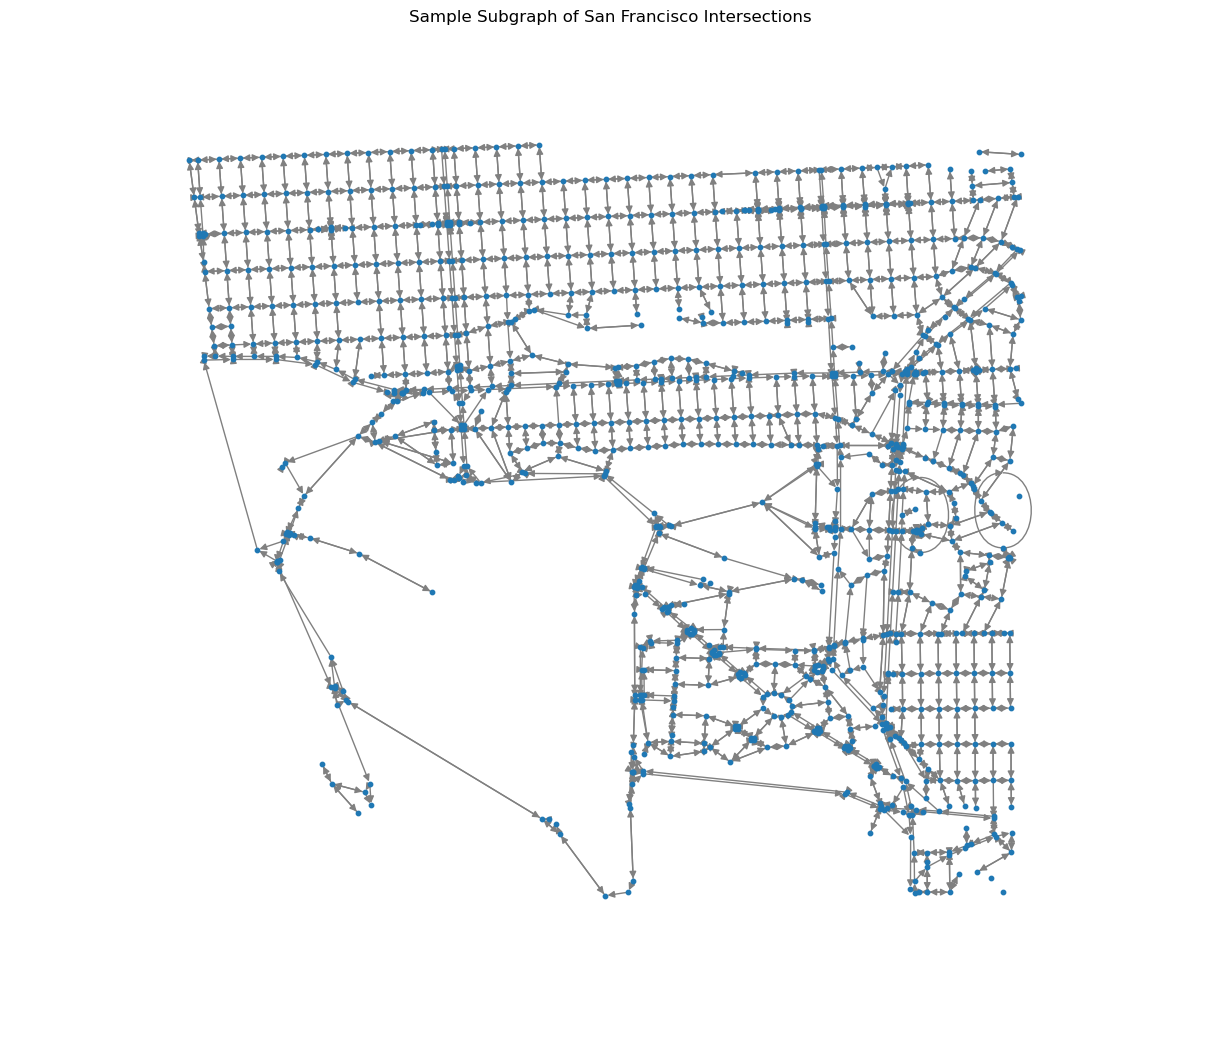

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# If you haven't already created G:
# G = nx.read_gpickle("data/processed/subgraph.pkl")

# Step 1: Limit to a smaller subgraph (optional, for better performance)
# Select 200 nodes with their connected edges for clearer plotting
sub_nodes = list(G.nodes())[:1000]
H = G.subgraph(sub_nodes).copy()

# Step 2: Extract node positions from lat/lon if available
pos = {n: (d['x'], d['y']) for n, d in H.nodes(data=True) if 'x' in d and 'y' in d}

# Step 3: Draw the graph
plt.figure(figsize=(12, 10))
nx.draw(
    H,
    pos=pos,
    node_size=10,
    edge_color="gray",
    width=1,
    with_labels=False
)
plt.title("Sample Subgraph of San Francisco Intersections")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")  # preserve aspect ratio
plt.show()


In [ ]:
import networkx as nx
import math

# Step 1: Find all connected components
components = list(nx.weakly_connected_components(G))

# Step 2: Identify the largest component (assumed to be the main graph)
largest_component = max(components, key=len)
main_graph_nodes = set(largest_component)

# Step 3: Find nodes outside the main graph (disconnected)
isolated_nodes = [node for component in components if component != largest_component for node in component]

print(f"Number of isolated nodes: {len(isolated_nodes)}")

# Step 4: Connect each isolated node to its nearest main graph node
def euclidean_dist(n1, n2):
    x1, y1 = G.nodes[n1]['x'], G.nodes[n1]['y']
    x2, y2 = G.nodes[n2]['x'], G.nodes[n2]['y']
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

for iso_node in isolated_nodes:
    # Find the closest node in the main graph
    min_dist = float('inf')
    closest_node = None
    for main_node in main_graph_nodes:
        try:
            dist = euclidean_dist(iso_node, main_node)
            if dist < min_dist:
                min_dist = dist
                closest_node = main_node
        except KeyError:
            continue  # Skip if coordinates are missing
    # if closest_node:
    #     # Add edge (you can add attributes like length here if needed)
    #     G.add_edge(iso_node, closest_node, length=min_dist)
    #     print(f"Connected {iso_node} to {closest_node} with distance {min_dist:.2f}")


Number of isolated nodes: 5
Connected 65303428 to 65312094 with distance 0.00
Connected 65348794 to 65322025 with distance 0.00
Connected 65370802 to 65337886 with distance 0.00
Connected 65350300 to 65337883 with distance 0.00
Connected 6469349555 to 65312094 with distance 0.00
